<a href="https://colab.research.google.com/github/Delhi-Hacks-2020/Predictor/blob/master/LSTM_Closing_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
sns.set_style()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
df = pd.read_csv('Google.csv')

In [44]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index("Date", drop=False, inplace=True)

In [45]:
df  =df.iloc[::-1]

In [46]:
df.drop(labels=['Date'],axis =1, inplace=True)

In [49]:
df = pd.DataFrame(df['Close'])
series = df['Close']
dates = series.index
dates

DatetimeIndex(['2019-12-31', '2019-12-30', '2019-12-27', '2019-12-26',
               '2019-12-24', '2019-12-23', '2019-12-20', '2019-12-19',
               '2019-12-18', '2019-12-17',
               ...
               '2009-01-15', '2009-01-14', '2009-01-13', '2009-01-12',
               '2009-01-09', '2009-01-08', '2009-01-07', '2009-01-06',
               '2009-01-05', '2009-01-02'],
              dtype='datetime64[ns]', name='Date', length=2768, freq=None)

In [50]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

In [51]:
series = np.array(df['Close'])

In [52]:
minmax = MinMaxScaler().fit(series.reshape(-1,1)) # Close index
series = minmax.transform(series.reshape(-1,1)) # Close index
pd.DataFrame(series, index = dates)

,0
Date,
2019-12-31,0.981097
2019-12-30,0.981359
2019-12-27,0.993587
2019-12-26,1.000000
2019-12-24,0.985225
...,...
2009-01-08,0.017397
2009-01-07,0.016094
2009-01-06,0.021033


In [53]:
ser_lat = series
y_test = series[-11:-1]
series = series[:-11]

In [54]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [55]:
TIME_STEPS = 10

X, y = split_sequence(series, 20, TIME_STEPS)
len(series)

2757

In [57]:

outputs = []
for _ in [TIME_STEPS]:
  X, y = split_sequence(series, 20, TIME_STEPS)
  n_input = TIME_STEPS
  '''
  generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)
  for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))
  '''   
  # define model
  
  model = Sequential([
  tf.keras.layers.Bidirectional(LSTM(128,activation='tanh', return_sequences=True, input_shape=(n_input,1))),
  tf.keras.layers.Bidirectional(LSTM(64, activation='tanh')),
  Dense(10)
  ])

  model.compile(optimizer='adam', loss='mean_squared_error')

  X = X.reshape((X.shape[0], X.shape[1], 1))
    
  model.fit(X,y, epochs=100, verbose=0)

  # make a one step prediction out of sample
  x_input = y_test.reshape((1, n_input,1))
  yhat = model.predict(x_input, verbose=0)
  outputs.append(yhat)


In [58]:
outputs = minmax.inverse_transform(outputs[0])
outputs

array([[161.76494, 155.01945, 162.4566 , 161.8273 , 171.07565, 166.23907,
        168.92407, 166.55835, 168.2572 , 169.49147]], dtype=float32)

In [60]:
actual = minmax.inverse_transform(y_test.reshape(-1,1))

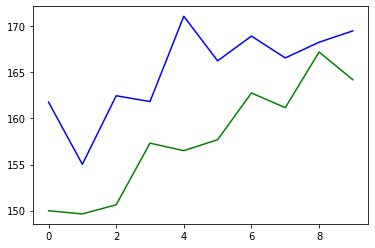

In [79]:
import matplotlib.pyplot as plt
plt.plot(outputs[0],'b')
plt.plot(actual,'g')
plt.show()

(1, 10)

In [40]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets
